In [7]:
%matplotlib inline
import os
import time
import numpy
import pandas as pd
import matplotlib

In [25]:
log_files = {'new': 'slurm-4236.out'}
# log_files = {1: 'slurm-3600.out', 4: 'slurm-3601.out', 16: 'slurm-3602.out', 'rwlock': 'slurm-4235.out'}

In [30]:
 def log_file_to_dataframe(log_file):
    fp = open(log_file, 'r')
    perf_records = []
    for line in fp:
        if line.startswith('PE ') and line.find('- total') != -1:
            tokens = line.split()

            # Sample line in log file:
            #   PE 6 - total 1336.802000 ms - metadata 54.481000 ms (50.733000 0.000000) - \
            #     summary 3.805000 ms (1.763000 0.072000 1.970000 | 0.065000 0.037000 0.048000 1.820000) - \
            #     edges 1278.047000 ms (1190.644000 80.641000) - neighbor updates 0.411000 ms - \
            #     abort 0.058000 ms - 0 spins - 9 / 16 PE neighbors  - partition window = , 1522 / 28900 active - \
            #     aborting? 0 - last step? 0 - remote cache hits=6688 misses=3553 age misses=0, feature cache hits=0 misses=0
            #
            # Sample new line in log file:
            #   PE 11 - total 42.046000 ms - metadata 26.715000 ms (26.212000 0.000000) - \
            #     summary 4.765000 ms (0.133000 0.023000 4.609000 | 1.428000 1.406000 1.281000 0.481000) - \
            #     edges 10.411000 ms (2.730000 7.445000) - neighbor updates 0.111000 ms - coupling 0.020000 ms - \
            #     throttling 0.024000 ms - 0 spins - 6 / 256 PE neighbors  - partition window = , 43 / 10000 active - \
            #     aborting? 0 - last step? 0 - remote cache hits=1611 misses=375 age misses=0, feature cache hits=0 misses=0
            index = 1
            pe = int(tokens[index])
            index += 3
            
            total = float(tokens[index])
            index += 4
            
            metadata = float(tokens[index])
            index += 6
            
            summary = float(tokens[index])
            index += 12
            
            edges = float(tokens[index])
            index += 7
            
            neighbor_updates = float(tokens[index])
            index  += 4
            
            
            coupling = float(tokens[index])
            index += 4
            
            throttling = float(tokens[index])
            index += 3
            
            spins = int(tokens[index])
            index += 3
            
            n_neighbors = int(tokens[index])
            index += 10
            
            active_partitions = int(tokens[index])
            index += 14
            
            cache_hits_str = tokens[index]
            cache_hits = int(cache_hits_str.split('=')[1])
            index += 1
            
            cache_misses_str = tokens[index]
            cache_misses = int(cache_misses_str.split('=')[1])
            index += 2
            
            cache_age_misses_str = tokens[index]
            cache_age_misses_str = cache_age_misses_str.split('=')[1]
            cache_age_misses_str = cache_age_misses_str[:-1]
            cache_age_misses = int(cache_age_misses_str)

            perf_records.append({'pe': pe,
                                 'total': total,
                                 'metadata': metadata,
                                 'summary': summary,
                                 'edges': edges,
                                 'neighbor_updates': neighbor_updates,
                                 'coupling': coupling,
                                 'throttling': throttling,
                                 'spins': spins,
                                 'n_neighbors': n_neighbors,
                                 'active_partitions': active_partitions,
                                 'cache_hits': cache_hits,
                                 'cache_misses': cache_misses,
                                 'cache_age_misses': cache_age_misses})
    fp.close()
    return pd.DataFrame(perf_records)

In [31]:
dfs = {}
for nnodes in log_files:
    dfs[nnodes] = log_file_to_dataframe(log_files[nnodes])

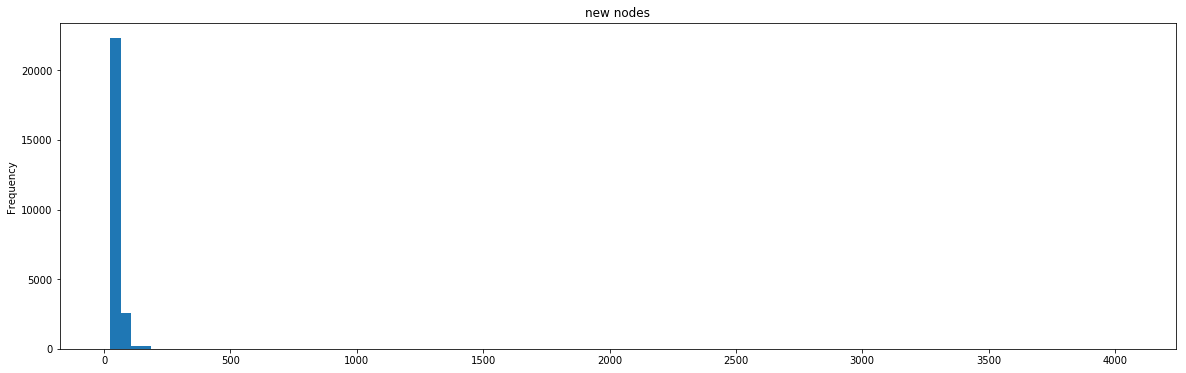

In [32]:
for nnodes in sorted(dfs.keys()):
    fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
    dfs[nnodes]['total'].plot(kind = 'hist', bins = 100, ax = ax, title = str(nnodes) + ' nodes')

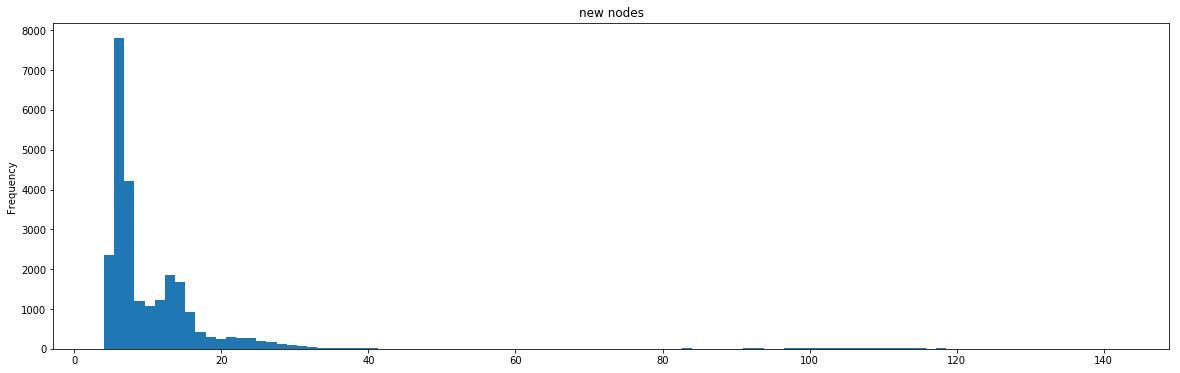

In [33]:
for nnodes in sorted(dfs.keys()):
    fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
    dfs[nnodes]['summary'].plot(kind = 'hist', bins = 100, ax = ax, title = str(nnodes) + ' nodes')

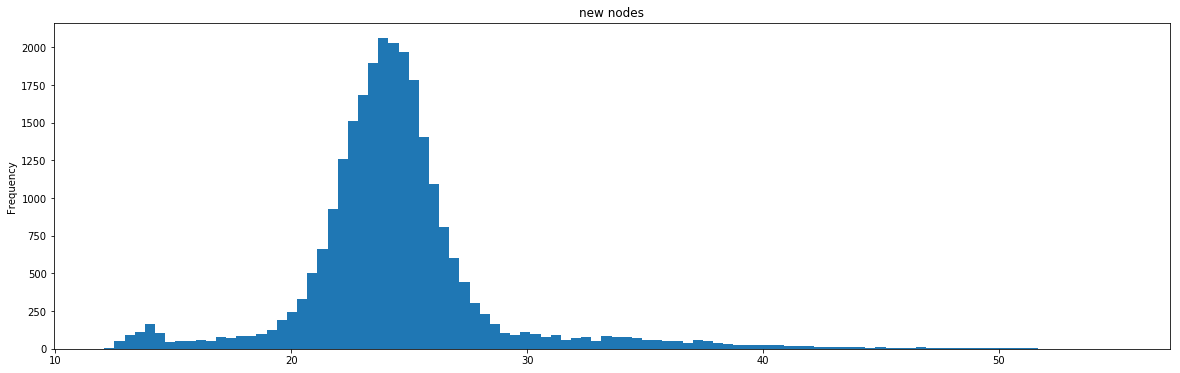

In [34]:
for nnodes in sorted(dfs.keys()):
    fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
    dfs[nnodes]['metadata'].plot(kind = 'hist', bins = 100, ax = ax, title = str(nnodes) + ' nodes')

In [35]:
dfs['new'].columns

Index([u'active_partitions', u'cache_age_misses', u'cache_hits',
       u'cache_misses', u'coupling', u'edges', u'metadata', u'n_neighbors',
       u'neighbor_updates', u'pe', u'spins', u'summary', u'throttling',
       u'total'],
      dtype='object')

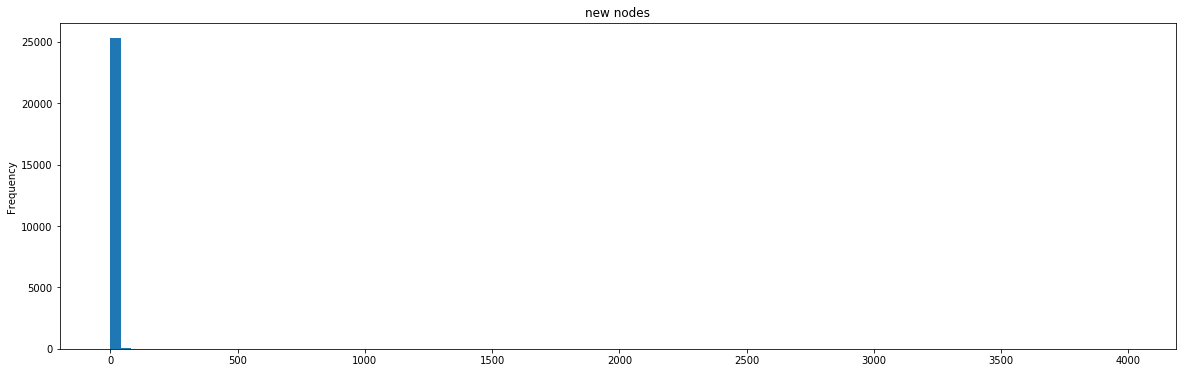

In [37]:
fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
dfs['new']['coupling'].plot(kind = 'hist', bins = 100, ax = ax,
                            title = str(nnodes) + ' nodes')

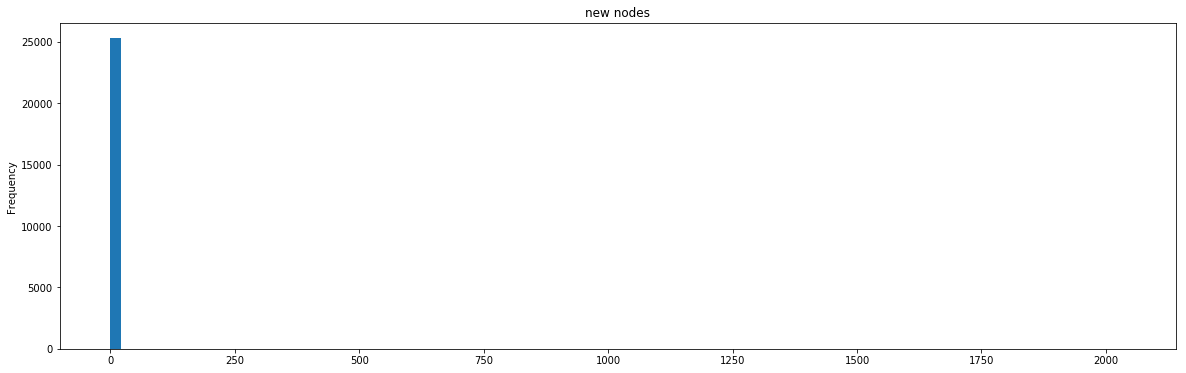

In [38]:
fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
dfs['new']['throttling'].plot(kind = 'hist', bins = 100, ax = ax,
                            title = str(nnodes) + ' nodes')

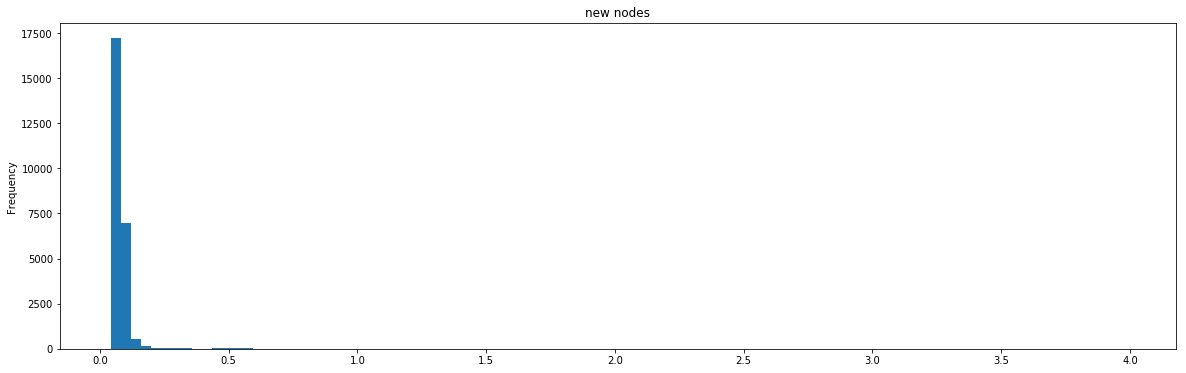

In [41]:
fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
dfs['new']['neighbor_updates'].plot(kind = 'hist', bins = 100, ax = ax,
                            title = str(nnodes) + ' nodes')

In [43]:
dfs['new']['coupling'].min()

0.016